In [2]:
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /home/patryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/patryk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/patryk/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import re
import pickle
import random
import json
import numpy as np
import os
import requests
import shutil
from PIL.ImageFile import ImageFile
from PIL import Image

import nltk
from gensim.models import KeyedVectors
import fasttext
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, r2_score
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from tqdm import tqdm
from typing import Union, Dict, Tuple, Optional

from datetime import datetime

import pandas as pd
import torch
import torch
import torchvision as tv
import torchvision.models as M
import torchvision.transforms as T
import cv2

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import seaborn as sns
import matplotlib as mpl

In [4]:
DATA_PATH = f"data/"
SEED = 0
N_FEATURES = 10000

# Train/Test split + data preprocessing


In [5]:
def preprocess_text(document):
    stemmer = WordNetLemmatizer()
    en_stop = stopwords.words("english")
    # Remove all the special characters
    document = re.sub(r"\W", " ", str(document))

    # remove all single characters
    document = re.sub(r"\s+[a-zA-Z]\s+", " ", document)

    # Remove single characters from the start
    document = re.sub(r"\^[a-zA-Z]\s+", " ", document)

    # Substituting multiple spaces with single space
    document = re.sub(r"\s+", " ", document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r"^b\s+", "", document)

    # Converting to Lowercase
    document = document.lower()

    # # Lemmatization
    # tokens = document.split()
    # tokens = [stemmer.lemmatize(word) for word in tokens]
    # tokens = [word for word in tokens if word not in en_stop]
    # tokens = [word for word in tokens if len(word) > 3]

    # # preprocessed_text = ' '.join(tokens)
    # preprocessed_text = tokens

    return document

In [6]:
df = pd.read_csv(f"{DATA_PATH}merged_data_youtube.csv", index_col=0)
df = df.dropna(subset=["view_count"])

RATIO = 0.9

indexes = list(range(len(df)))
random.seed(42)
random.shuffle(indexes)

df_train = df.iloc[indexes[: int(0.9 * len(df))]].copy()
df_test = df.iloc[indexes[len(df_train) :]].copy()


df_view_mean = df_train["view_count"].mean()
df_train["view_count"] -= df_view_mean

df_view_std = df_train["view_count"].std()
df_train["view_count"] /= df_view_std

df_test["view_count"] -= df_view_mean
df_test["view_count"] /= df_view_std

df_train["title"] = df_train["title"].apply(preprocess_text)
df_test["title"] = df_test["title"].apply(preprocess_text)

In [7]:
df_view_std

8797020.75652489

# TFIDF vectorizer

In [8]:
# vectorizer = TfidfVectorizer(
#     stop_words="english", max_features=10000, ngram_range=(1, 2)
# )

In [9]:
# with open("data/vectorizer.pckl", "wb") as file:
#     pickle.dump(vectorizer, file)    

In [10]:
with open("data/vectorizer.pckl", "rb") as file:
    vectorizer = pickle.load(file)    

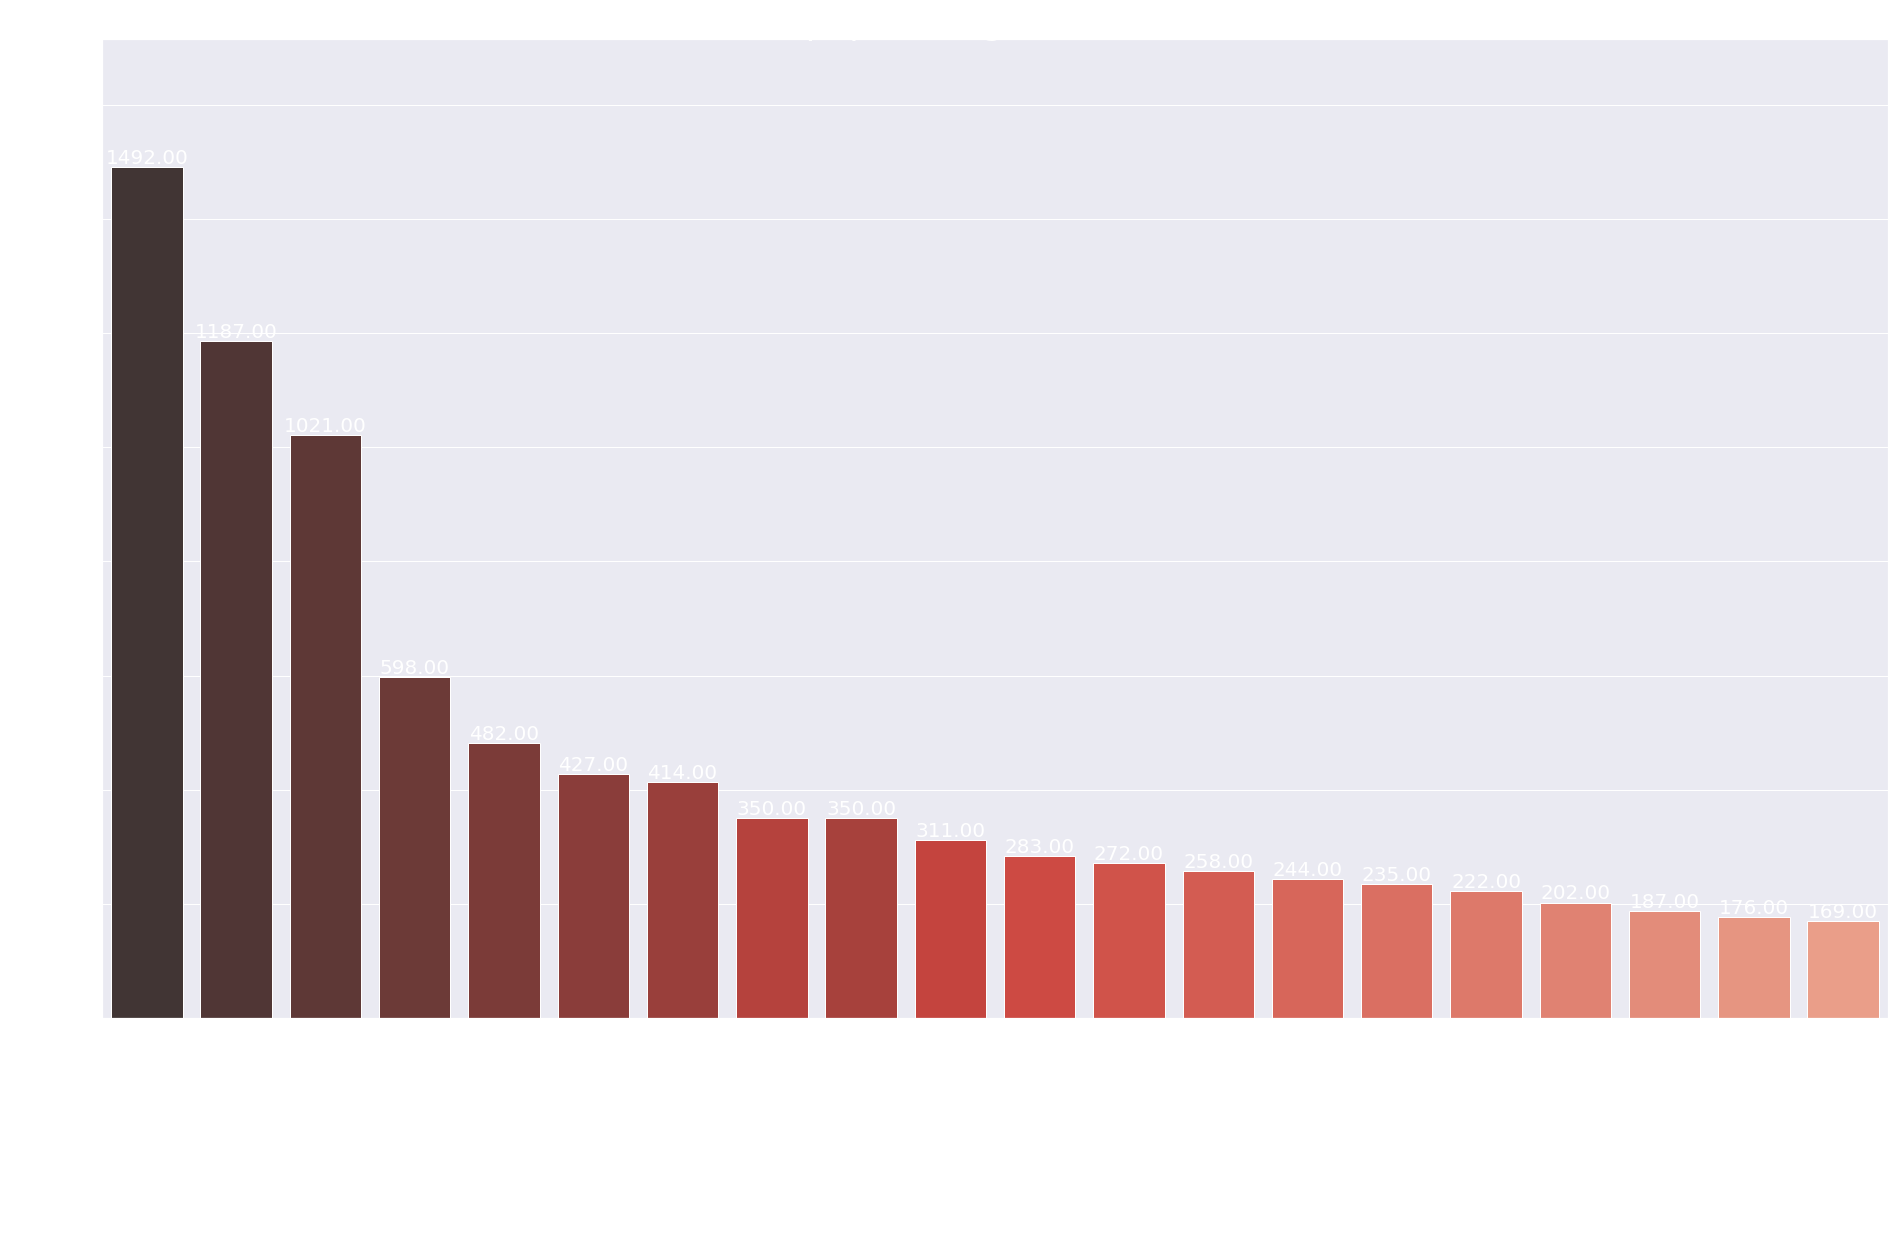

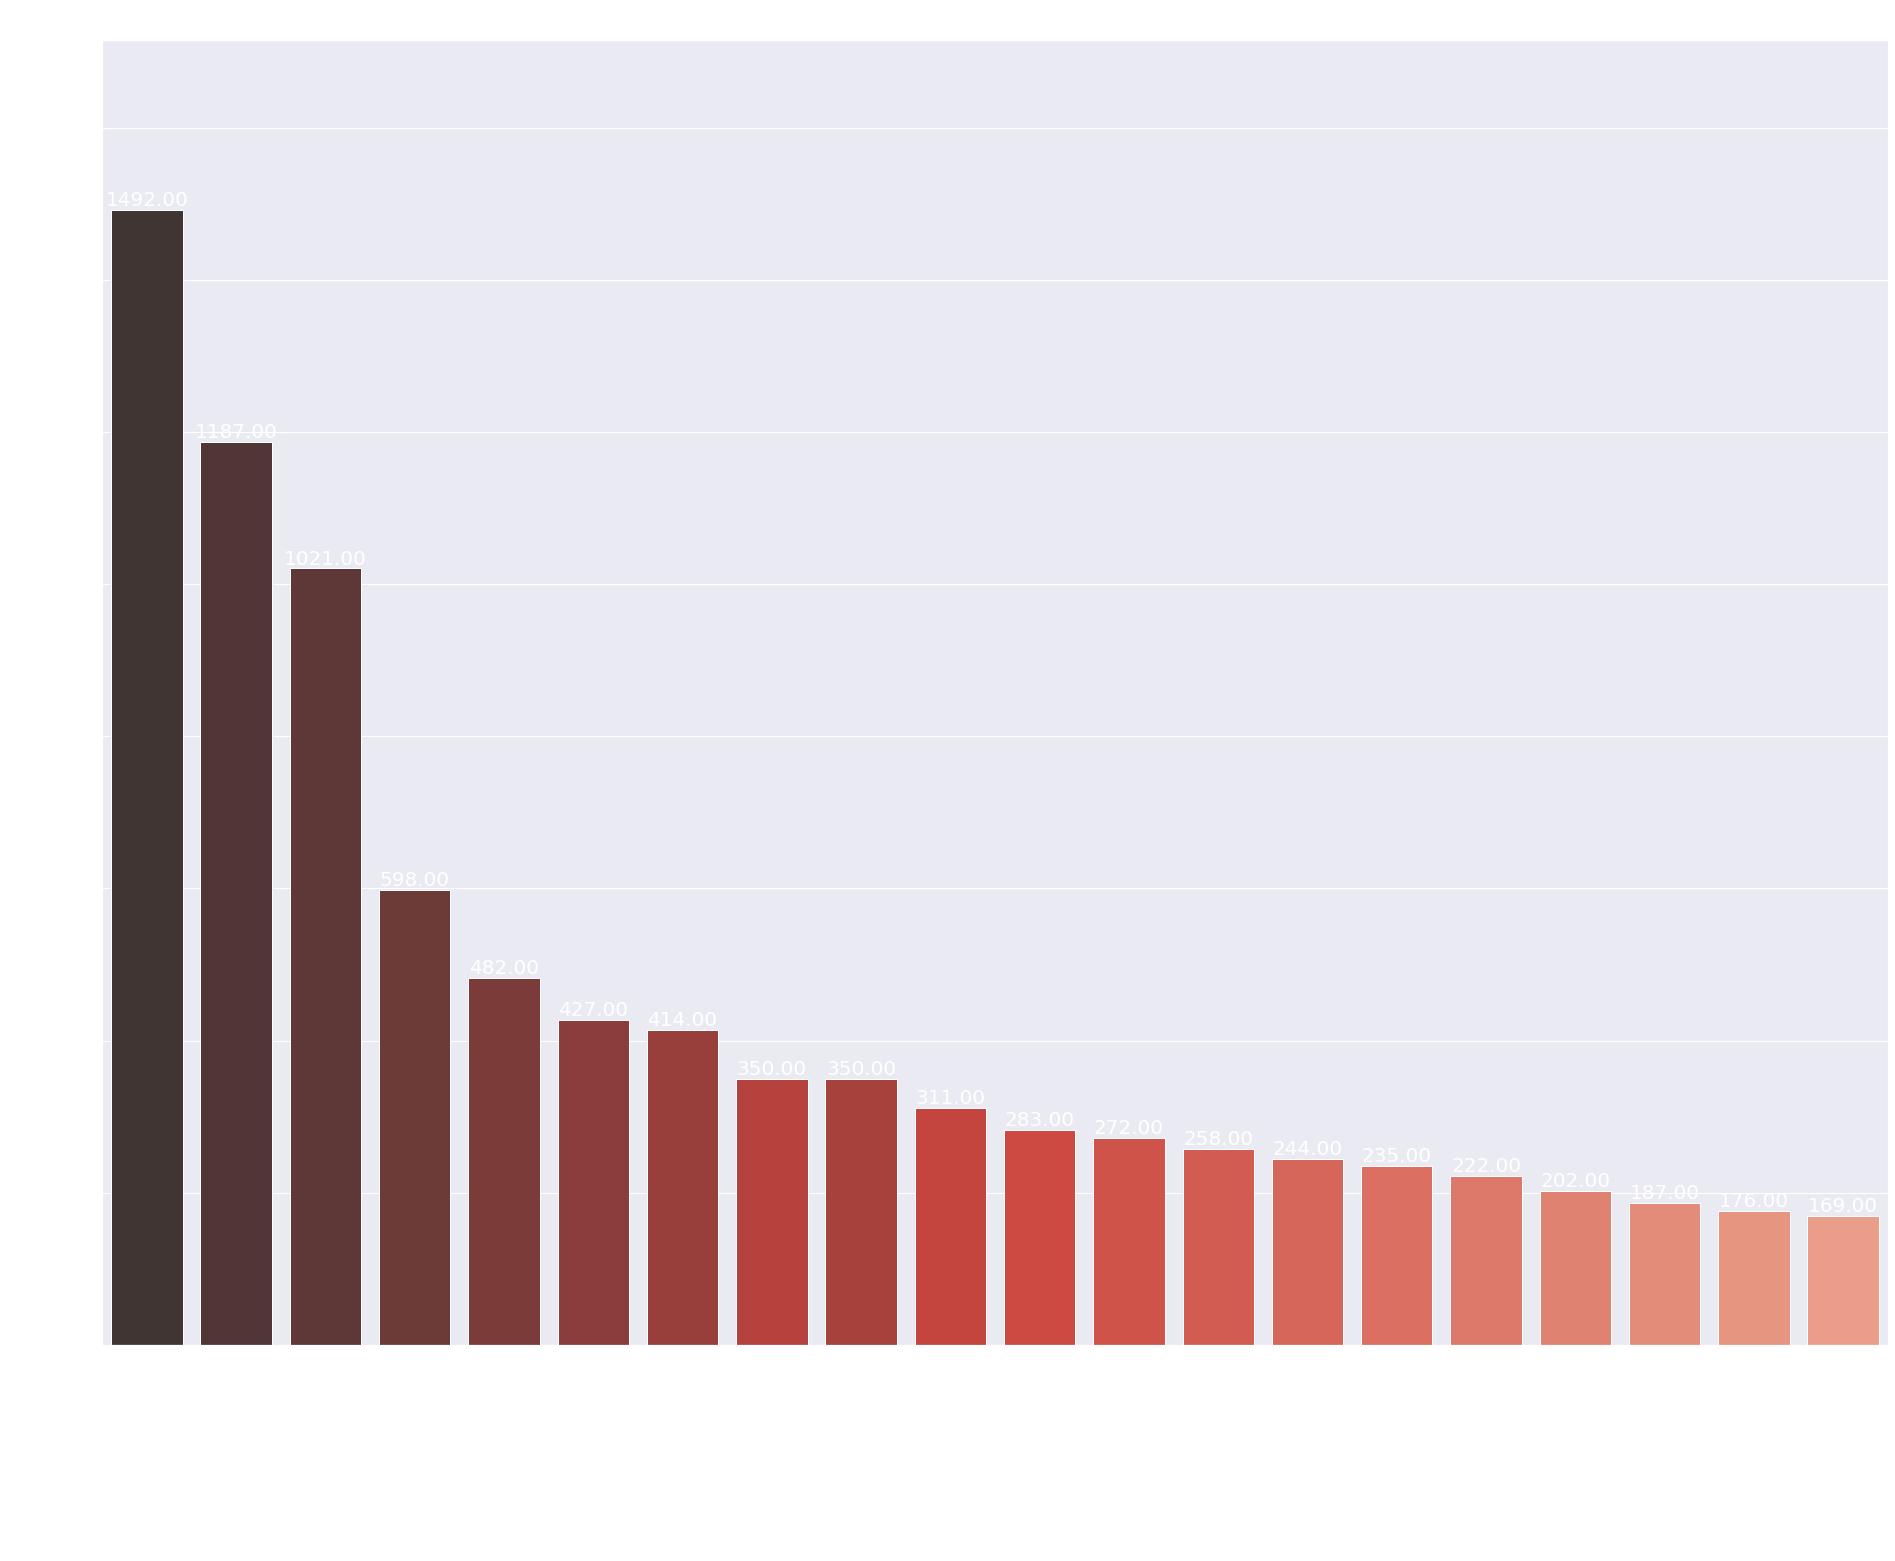

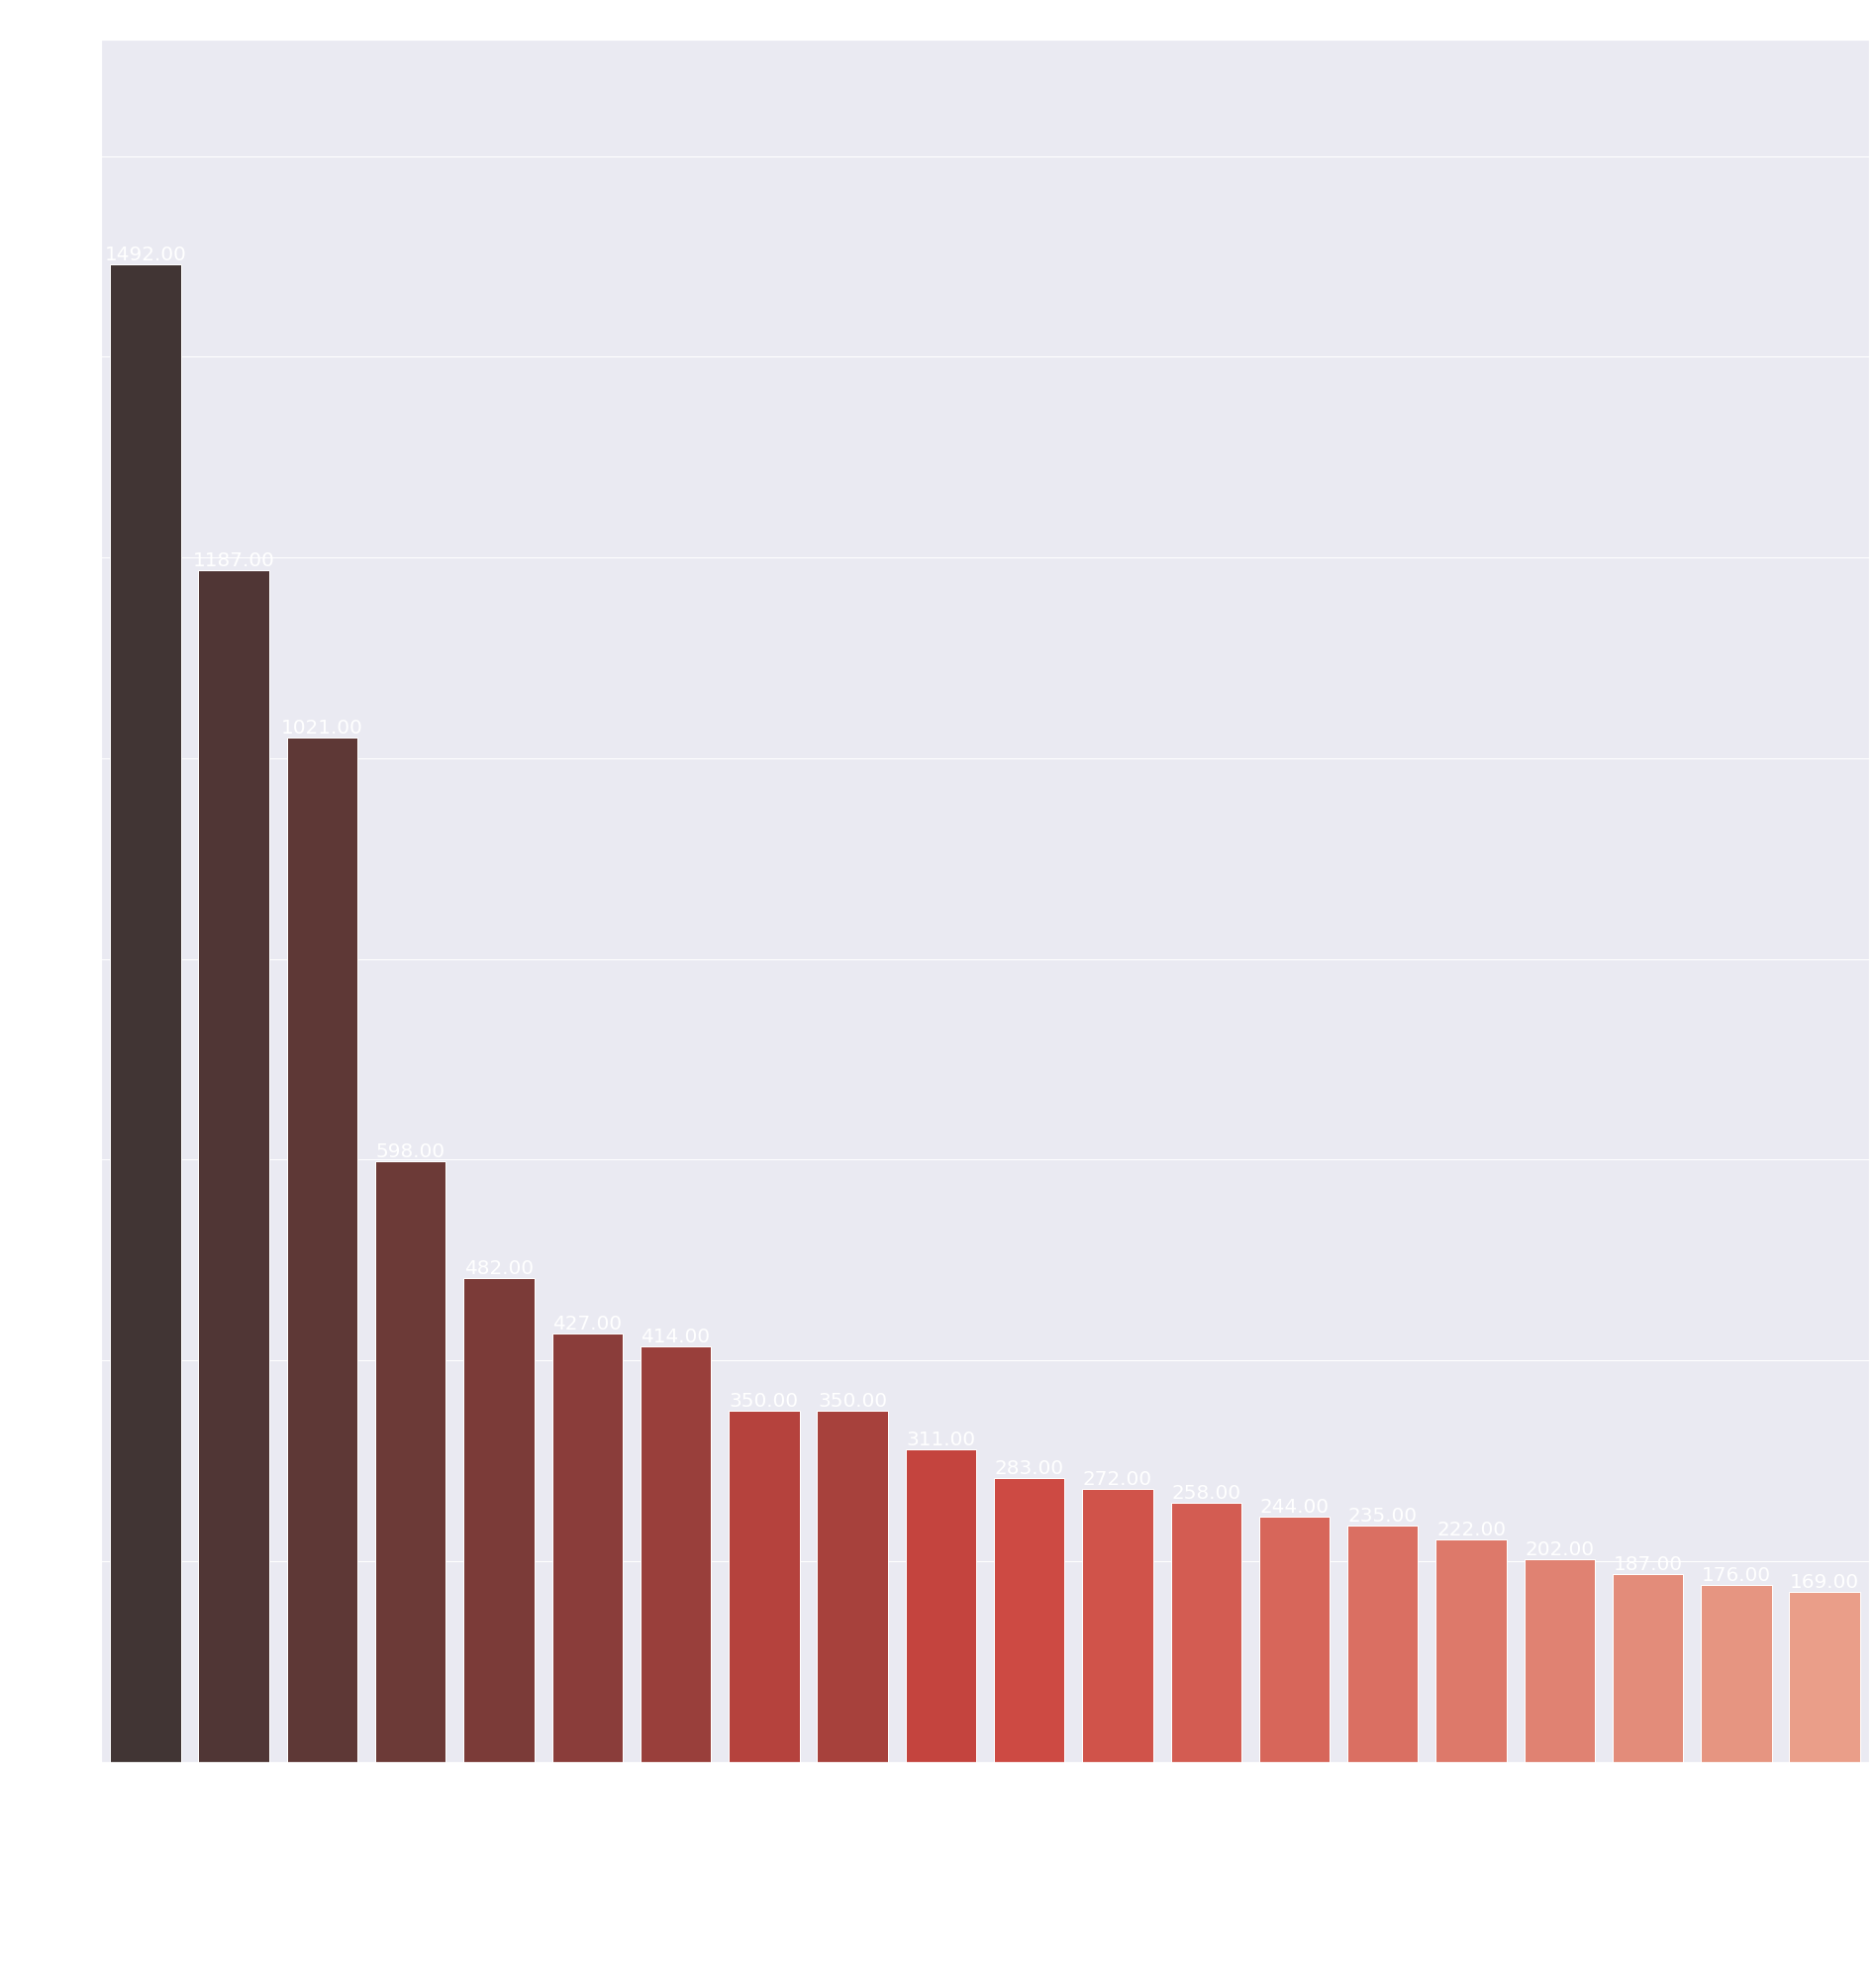

In [15]:

en_stop = stopwords.words("english")
tokens = (" ".join(df_train["title"])).split()
words = [word for word in tokens if word not in en_stop]

grams_2 = nltk.ngrams(words, 2)
freq_2 = nltk.FreqDist(grams_2)
data = [{" ".join(gram): freq} for (gram, freq) in freq_2.items()]
data.sort(key=lambda x: -list(x.values())[0])

keys = np.array([list(item.keys())[0] for item in data])[:20]
values = np.array([list(item.values())[0] for item in data])[:20]

order = np.argsort(values)[::-1]

for i in [18, 24, 32]:
    sns.set_theme()

    COLOR = 'white'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR

    pal_red = sns.color_palette("Reds_d", len(keys))
    fig = plt.figure(figsize=(32, i))
    graph = sns.barplot(x = keys, y = values, palette= np.array(pal_red[::-1])[order])
    graph.set_title("Most popular bigrams in dataset", fontsize=35)
    ax = plt.gca()
    plt.ylim(0, max(values) + 0.15*max(values)) 
    ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
    ax.tick_params(axis='y', which='major', labelsize=30)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=27)
    plt.savefig(f"words_32_{i}.png", transparent=True)
    plt.show()


In [9]:
df_train["title_tf_idf"] = np.array(vectorizer.fit_transform(df_train["title"]))
df_test["title_tf_idf"] = np.array(vectorizer.transform(df_test["title"]))

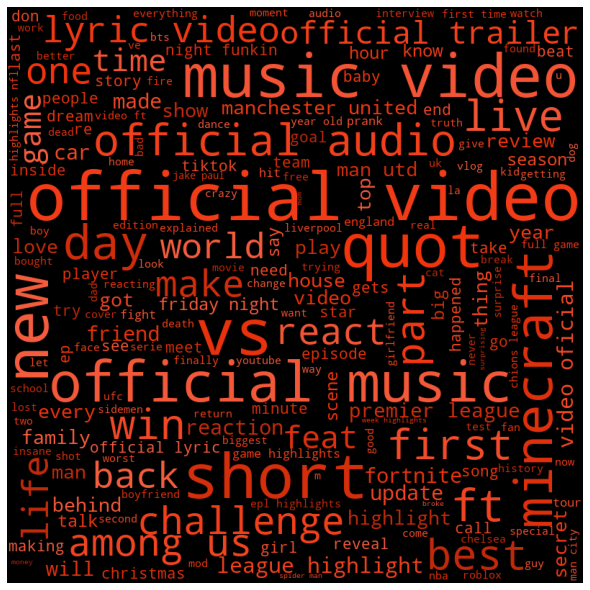

In [10]:
#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return(f"hsl(10, 89%, {random.randint(40, 60)}%)")

wordcloud = WordCloud(
    width=800, height=800, background_color="black", min_font_size=10, color_func = grey_color_func
).generate(" ".join(df_train["title"]).replace("amp", "").replace(" v ", " ").lower())

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud.svg")

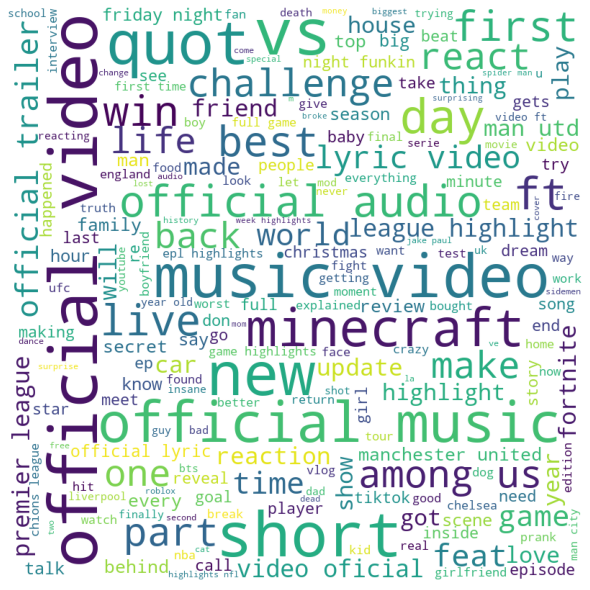

In [11]:
wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10
).generate(" ".join(df_train["title"]).replace("amp", "").replace(" v ", " ").lower())

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud.svg")

# Network

In [12]:
class ThumbLight(nn.Module):
    def __init__(self, kwargs):
        super(ThumbLight, self).__init__()

        self.num_classes = kwargs.get("num_classes", 1)
        self.resnet_size = kwargs.get("resnet_size", 512)
        self.text_input_size = kwargs.get("input_size", 10000)
        self.hidden_sizes = kwargs.get("hidden_sizes", [256, 64])
        
        if self.resnet_size == 512:
            self.resnet = M.resnet18(pretrained=False)
        elif self.resnet_size == 2048:
            self.resnet = M.resnet50(pretrained=False)

        self.resnet.fc = torch.nn.Identity()

        self.fc_text = nn.Linear(self.text_input_size, self.hidden_sizes[0])

        self.fc_1 = nn.Linear(
            self.resnet_size + self.hidden_sizes[0], self.hidden_sizes[0]
        )  # fully connected 1
        self.fc_2 = nn.Linear(
            self.hidden_sizes[0], self.hidden_sizes[1]
        )  # fully connected 1

        self.fc_3 = nn.Linear(
            self.hidden_sizes[1], self.num_classes
        )  # fully connected last layer
        self.relu = nn.ReLU()
        self.drop = torch.nn.Dropout(p=0.5, inplace=False)

    def forward(self, text, image):
        text = self.fc_text(text)
        # imgs = torch.cat([self.image_data_loader.dataset[img][0].unsqueeze(dim=0) for img in image]).cuda()
        image = self.resnet(image)

        out = torch.cat((text, image), axis=1)

        out = self.relu(out)
        out = self.fc_1(out)  # first Dense
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc_2(out)  # first Dense
        out = self.drop(out)
        out = self.relu(out)  # relu
        out = self.fc_3(out)
        return out

In [13]:
def _ensure_exists(path_out: str) -> None:
    if os.path.exists(path_out):
        return
    os.makedirs(path_out)


def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def calc_fscore(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return f1_score(y_true, preds, average="macro")


def calc_r2score(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return r2_score(
        y_true.detach().numpy(),
        y_pred.detach().numpy(),
        multioutput="variance_weighted",
    )


def calc_precission(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return precision_score(y_true, preds, average="macro", labels=np.unique(preds))


def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader,
    _type: str = "views",
    device: str = "cuda",
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    loss = 0
    score_sum = 0
    _all = 0
    iters = 0
    for texts_batch, images_batch, views_batch, trends_batch in dataloader:
        if _type == "views":
            target = views_batch
        elif _type == "trends":
            target = trends_batch

        y_pred = model(texts_batch.to(device), images_batch.to(device))
        _all += len(y_pred)
        iters += 1
        
        if _type == "views":
            target = target.float().unsqueeze(dim=1)
        
        loss += loss_fn(y_pred, target.to(device))
        
        if _type == "views":
            score_sum += r2_score(y_pred.cpu(), target)
        elif _type == "trends":
            score_sum += calc_fscore(y_pred.cpu(), target.unsqueeze(dim=1))
            
    return loss / _all, score_sum / iters


def fit(
    model: nn.Module,
    optimizer: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    writer: SummaryWriter,
    test_dl: Union[None, DataLoader] = None,
    epochs: int = 50,
    print_metrics: bool = True,
    patience: int = 5,
    output_path: str = "data/checkpoints/best",
    run_prefix: str = "early_stopping",
    _type: str = "views",  # views / trend
    device: str = "cuda",
) -> Dict[str, list]:
    losses = {"train": [], "val": [], "test": []}
    scores = {"train": [], "val": [], "test": []}

    min_val_loss = float('inf')
    current_patience = 0
    for epoch in tqdm(range(epochs)):
        model.train()  # Przełączenie na tryb uczenia modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
        for texts_batch, images_batch, views_batch, trends_batch in train_dl:
            if _type == "views":
                target = views_batch
            elif _type == "trends":
                target = trends_batch

            texts_batch, images_batch, target = (
                texts_batch.to(device),
                images_batch.to(device),
                target.to(device),
            )
            y_pred = model(
                texts_batch, images_batch
            )  # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            
            if _type == "views":
                target = target.float().unsqueeze(dim=1)
            
            loss = loss_fn(y_pred, target)  # Policzenie funkcji straty

            loss.backward()  # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimizer.step()  # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimizer.zero_grad()  # Wyzerowanie gradientów w modelu, alternatywnie można wywołać model.zero_grad()

        model.eval()  # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
        with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
            train_loss, train_score = validate(
                model, loss_fn, train_dl, _type=_type, device=device
            )
            val_loss, val_score = validate(
                model, loss_fn, val_dl, _type=_type, device=device
            )

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                current_patience = 0
                torch.save(
                    obj={
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    f=output_path + "_" + run_prefix,
                )
            else:
                current_patience += 1

            if test_dl:
                test_loss, test_score = validate(
                    model, loss_fn, test_dl, _type=_type, device=device
                )
                losses["test"].append(test_loss)
                scores["test"].append(test_score)

        losses["train"].append(train_loss)
        losses["val"].append(val_loss)

        scores["train"].append(train_score)
        scores["val"].append(val_score)

        writer.add_scalars(
            main_tag=f"{run_prefix} loss",
            tag_scalar_dict={"train": train_loss, "dev": val_loss},
            global_step=epoch + 1,
        )

        def score_type(_type):
            if _type == "views":
                return "r2"
            elif _type == "trends":
                return "f1"
        
        
        writer.add_scalars(
            main_tag=f"{run_prefix} {score_type(_type)} score",
            tag_scalar_dict={"train": train_score, "dev": val_score},
            global_step=epoch + 1,
        )

        if print_metrics:
            print(
                f"Epoch {epoch}: "
                f"train loss = {train_loss:.3f} ({score_type(_type)}: {train_score:.3f})"
                f"validation loss = {val_loss:.3f} ({score_type(_type)}: {val_score:.3f}))"
            )

        if current_patience >= patience:
            break

    model.eval()  # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    return losses, scores

In [14]:
class TitleDataset(torch.utils.data.Dataset):
    def __init__(self, all_data: list, data_transform: T.Compose):
        self.all_data = all_data
        self.data_transform = data_transform

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        title, video_id, view_count, target = self.all_data[idx]
        try:
            img = Image.open("data/images/%s.jpg" % video_id)
        except FileNotFoundError:
            url = f'https://img.youtube.com/vi/{video_id}/hqdefault.jpg'
            response = requests.get(url, stream=True)
            with open("data/images/%s.jpg" % video_id, 'wb') as out_file:
                shutil.copyfileobj(response.raw, out_file)
            del response
            img = Image.open("data/images/%s.jpg" % video_id)
            
        
        return (
            title.toarray()
            .astype("float32")
            .squeeze(),  # sparse matrix to dense matrix
            self.data_transform(img),
            view_count,
            target,
        )

In [15]:
all_data_train = []
all_data_test = []

for _, row in df_train.iterrows():
    all_data_train.append(
        [row["title_tf_idf"], row["video_id"], row["view_count"], row["target"]]
    )

for _, row in df_test.iterrows():
    all_data_test.append(
        [row["title_tf_idf"], row["video_id"], row["view_count"], row["target"]]
    )

with open("all_data_train.pkl", "wb") as file:
    pickle.dump(all_data_train, file)

with open("all_data_test.pkl", "wb") as file:
    pickle.dump(all_data_test, file)

In [16]:
with open("all_data_train.pkl", "rb") as file:
    all_data_train = pickle.load(file)

with open("all_data_test.pkl", "rb") as file:
    all_data_test = pickle.load(file)
# all_data = all_data[:500]

In [17]:
BATCH_SIZE = 16
models = {
    "ThumbaitLight18View": {
        "type": "views",
        "kwargs": {
            "num_classes": 1,
            "resnet_size": 512,
            "text_input_size": 10000,
            "hidden_sizes": [256, 64],
            "learning_rate": 0.0001,
        },
    },
    "ThumbaitLight50View": {
        "type": "views",
        "kwargs": {
            "num_classes": 1,
            "resnet_size": 2048,
            "text_input_size": 10000,
            "hidden_sizes": [256, 64],
            "learning_rate": 0.0001,
        },
    },
    "ThumbaitLight18Trend": {
        "type": "trends",
        "kwargs": {
            "num_classes": 2,
            "resnet_size": 512,
            "text_input_size": 10000,
            "hidden_sizes": [256, 64],
            "learning_rate": 0.0001,
        },
    },
    "ThumbaitLight50Trend": {
        "type": "trends",
        "kwargs": {
            "num_classes": 2,
            "resnet_size": 2048,
            "text_input_size": 10000,
            "hidden_sizes": [256, 64],
            "learning_rate": 0.0001,
        },
    },
}


data_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Resize(size=(180, 240)),
    ]
)


for model_name in models:
    models[model_name]["train"] = TitleDataset(all_data_train, data_transform)
    models[model_name]["test"] = TitleDataset(all_data_test, data_transform)
    models[model_name]["train_dl"] = DataLoader(
        models[model_name]["train"], batch_size=BATCH_SIZE
    )
    models[model_name]["test_dl"] = DataLoader(
        models[model_name]["test"], batch_size=BATCH_SIZE
    )

In [40]:
log_dir = "tensorboard_logs"
_ensure_exists(log_dir)

writer_tensorboard = SummaryWriter(log_dir)

%reload_ext tensorboard
%tensorboard --logdir $log_dir --port=6012

In [22]:
EPOCHS = 200

models_to_train = [
    # "ThumbaitLight18View",
    # "ThumbaitLight50View",
    "ThumbaitLight18Trend",
    # "ThumbaitLight50Trend",
]


for model_name in models_to_train:
    time_stamp = datetime.now().strftime("%d_%m_%y_%H_%M_%S")
    _type = models[model_name]["type"]
    kwargs = models[model_name]["kwargs"]
    conf_path = f"data/checkpoints/configs"
    _ensure_exists(conf_path)

    models[model_name]["newest_prefix"] = model_name + "_" + _type + "_" + time_stamp

    with open(
        os.path.join(conf_path, models[model_name]["newest_prefix"] + ".json"), "w"
    ) as file:
        json.dump({model_name: {"type": _type, "kwargs": kwargs}}, file)

    models[model_name]["model"] = ThumbLight(kwargs).cuda()
    
    if _type == "views":
        models[model_name]["loss_fn"] = torch.nn.MSELoss(reduction="sum")
    elif _type == "trends":
        models[model_name]["loss_fn"] = torch.nn.CrossEntropyLoss(reduction="sum")
        
    models[model_name]["optimizer"] = torch.optim.AdamW(
        models[model_name]["model"].parameters(), lr=kwargs["learning_rate"]
    )

    result = fit(
        model=models[model_name]["model"],
        optimizer=models[model_name]["optimizer"],
        loss_fn=models[model_name]["loss_fn"],
        train_dl=models[model_name]["train_dl"],
        val_dl=models[model_name]["test_dl"],
        writer=writer_tensorboard,
        epochs=EPOCHS,
        patience=30,
        run_prefix=model_name + "_" + _type + "_" + time_stamp,
        print_metrics=True,
        _type=_type,
        device="cuda"
    )

    checkpoint = torch.load(
        f"data/checkpoints/best_{models[model_name]['newest_prefix']}"
    )
    models[model_name]["model"].load_state_dict(checkpoint["model_state_dict"])
    models[model_name]["optimizer"].load_state_dict(checkpoint["optimizer_state_dict"])

  0%|          | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [24]:
batch_train= next(iter(models[model_name]["train_dl"]))
batch_test= next(iter(models[model_name]["test_dl"]))


print(models["ThumbaitLight18View"]["model"](batch_train[0].cuda(), batch_train[1].cuda()))
print(models["ThumbaitLight18View"]["model"](batch_test[0].cuda(), batch_test[1].cuda()))

KeyError: 'model'

In [39]:
batch_train[2]

tensor([-0.2036, -0.1514, -0.2204, -0.1748, -0.2572, -0.1918,  6.9235,  1.1322,
        -0.2420, -0.1697, -0.1806, -0.2758, -0.1334, -0.2387, -0.2146,  0.0722],
       dtype=torch.float64)